In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.stattools import coint
from itertools import combinations, product
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

# Loading Data

In [2]:
df = pd.read_csv("FinalProject-Singapore.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.Date = df.Date.values[::-1]

In [3]:
cols_to_plot = ['STI_Price', 'SPY_Price', 'SHG_Price', 'US Interest Rates',
                'China Interest Rates ', 'Production Index United States',
                'Production Index China', 'CNY', 'USD']
return_cols_to_plot = []

for col in cols_to_plot:
    return_cols_to_plot.append(col+"_returns")

In [4]:
return_cols_to_plot = ['STI_Price_returns',
                        'SPY_Price_returns',
                        'SHG_Price_returns',
                        'US Interest Rates_returns',
                        'China Interest Rates ',
                        'Production Index United States_returns',
                        'Production Index China_returns',
                        'CNY_returns',
                        'USD_returns']

#### D(1) - Returns Data

In [5]:
for col in cols_to_plot:
    df[f'{col}_returns'] = df[col].pct_change().fillna(0)

# Data Exploration

## Description of Data
**Singapore**
* STI: Singapore FTSE Straight Times Index (Investing.com)

**United States**
* SPY: S&P 500 Prices (Investing.com)
* US Interest Rates: Discount Rate (FRED)
* Production Index United States: Production: Industry: Total Industry Excluding Construction for United States (FRED)
* USD: How many Singpaore dollars are needed to purchase a US Dollar (Investing.com)

**China**
* SHG: Shanghai Composite Index Prices
* Chinese Interest Rates: Discount Rate (FRED)
* Production Index China: Production: Industry: Total Industry Excluding Construction for United China (FRED)
* CNY: How many Singpaore dollars are needed to purchase a Chinese Yen

## Observing Data

#### Frequency Distribution

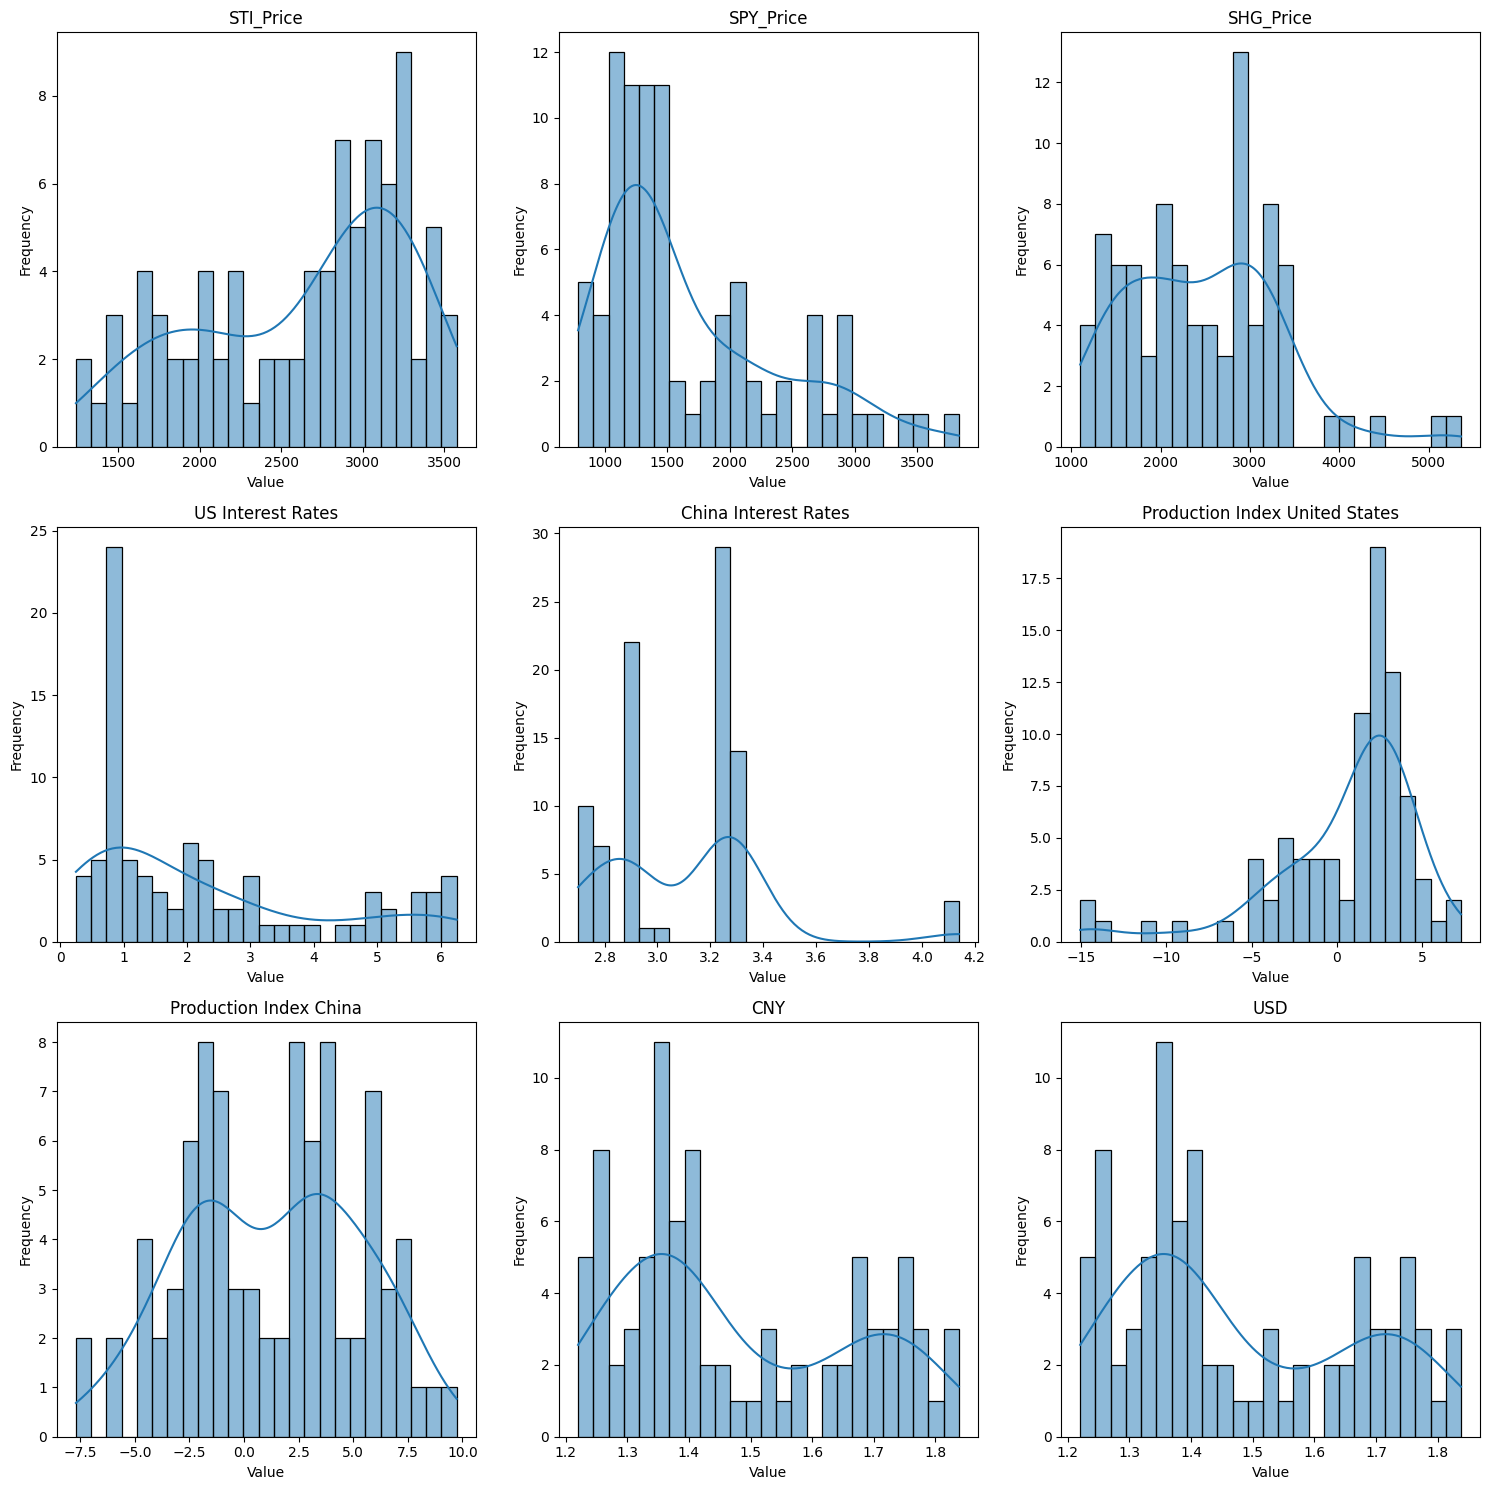

In [6]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=25)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Over Time

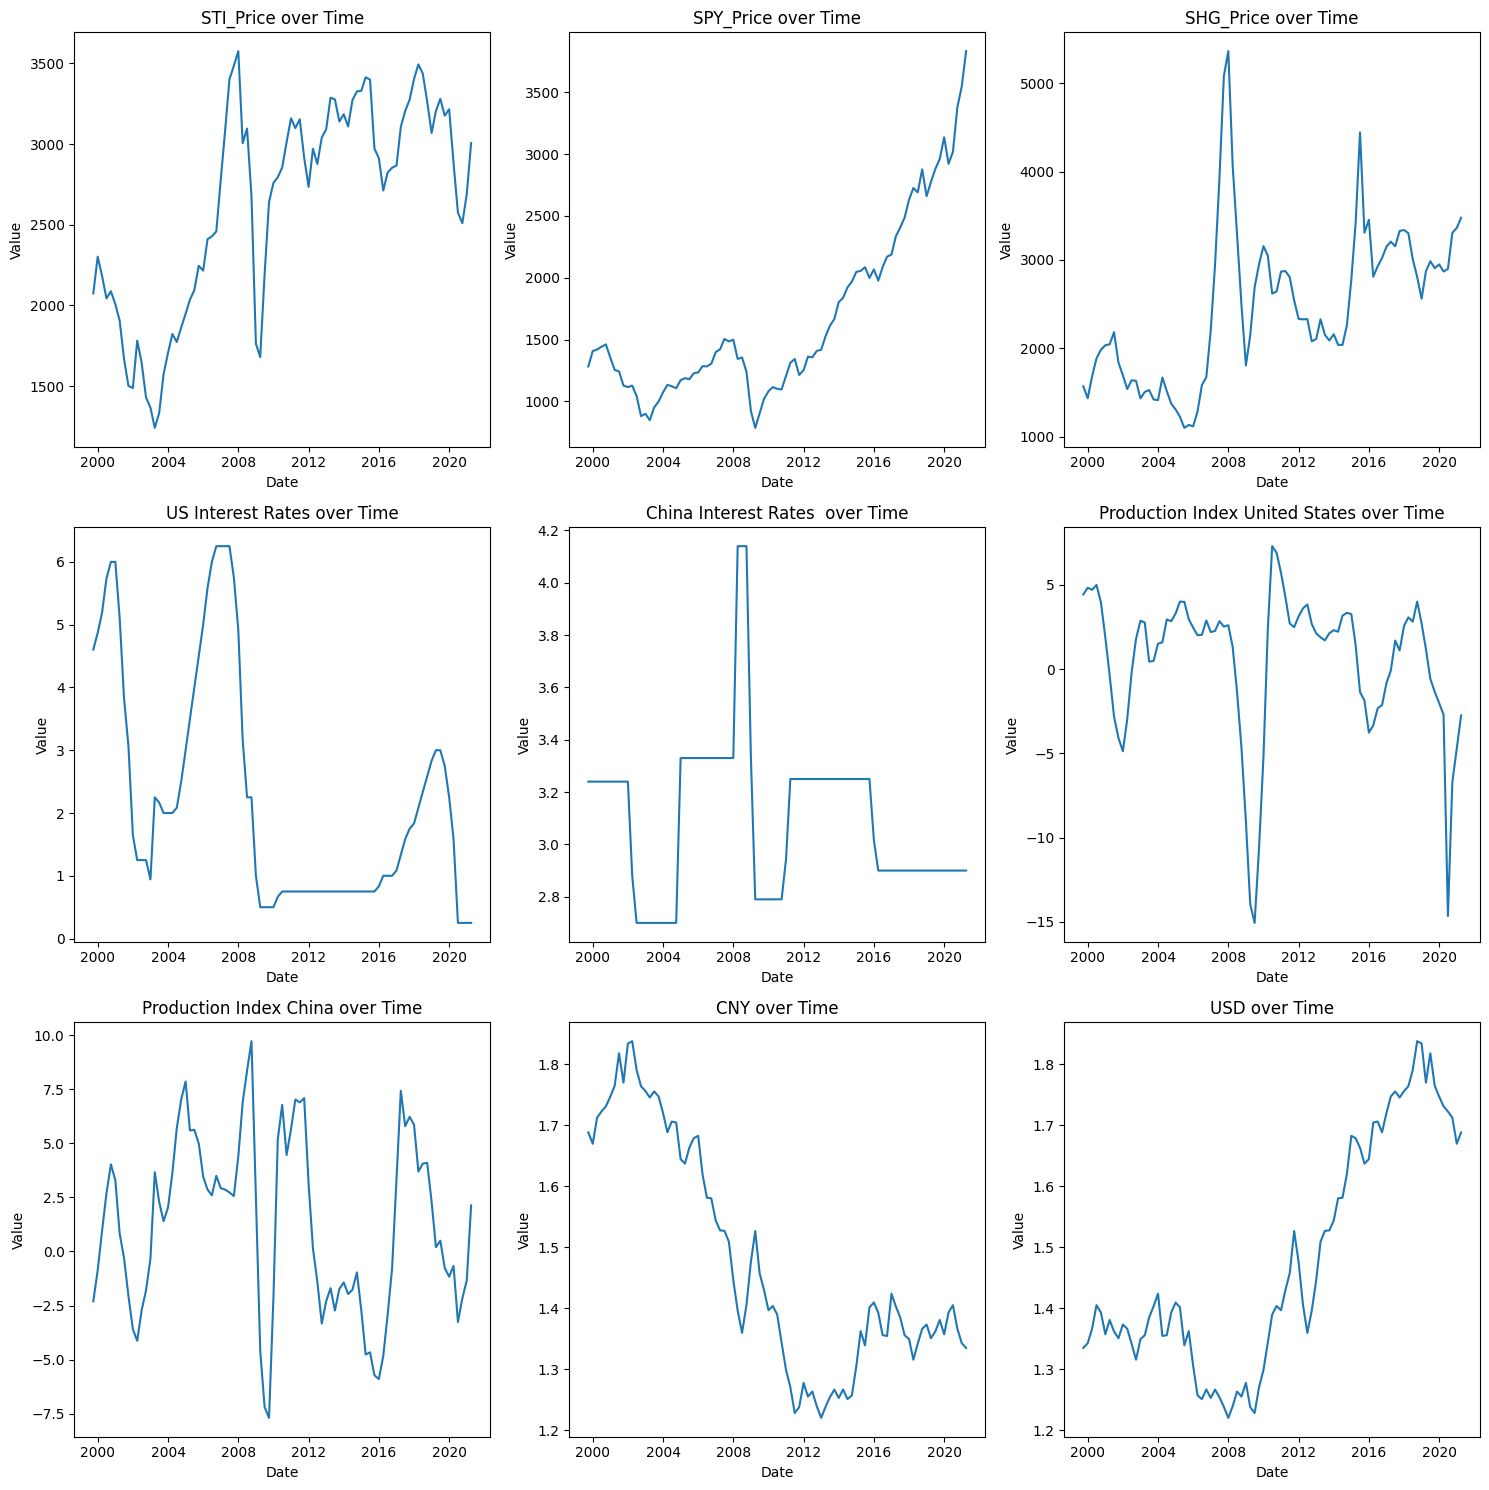

In [7]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.lineplot(x=df['Date'], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Returns

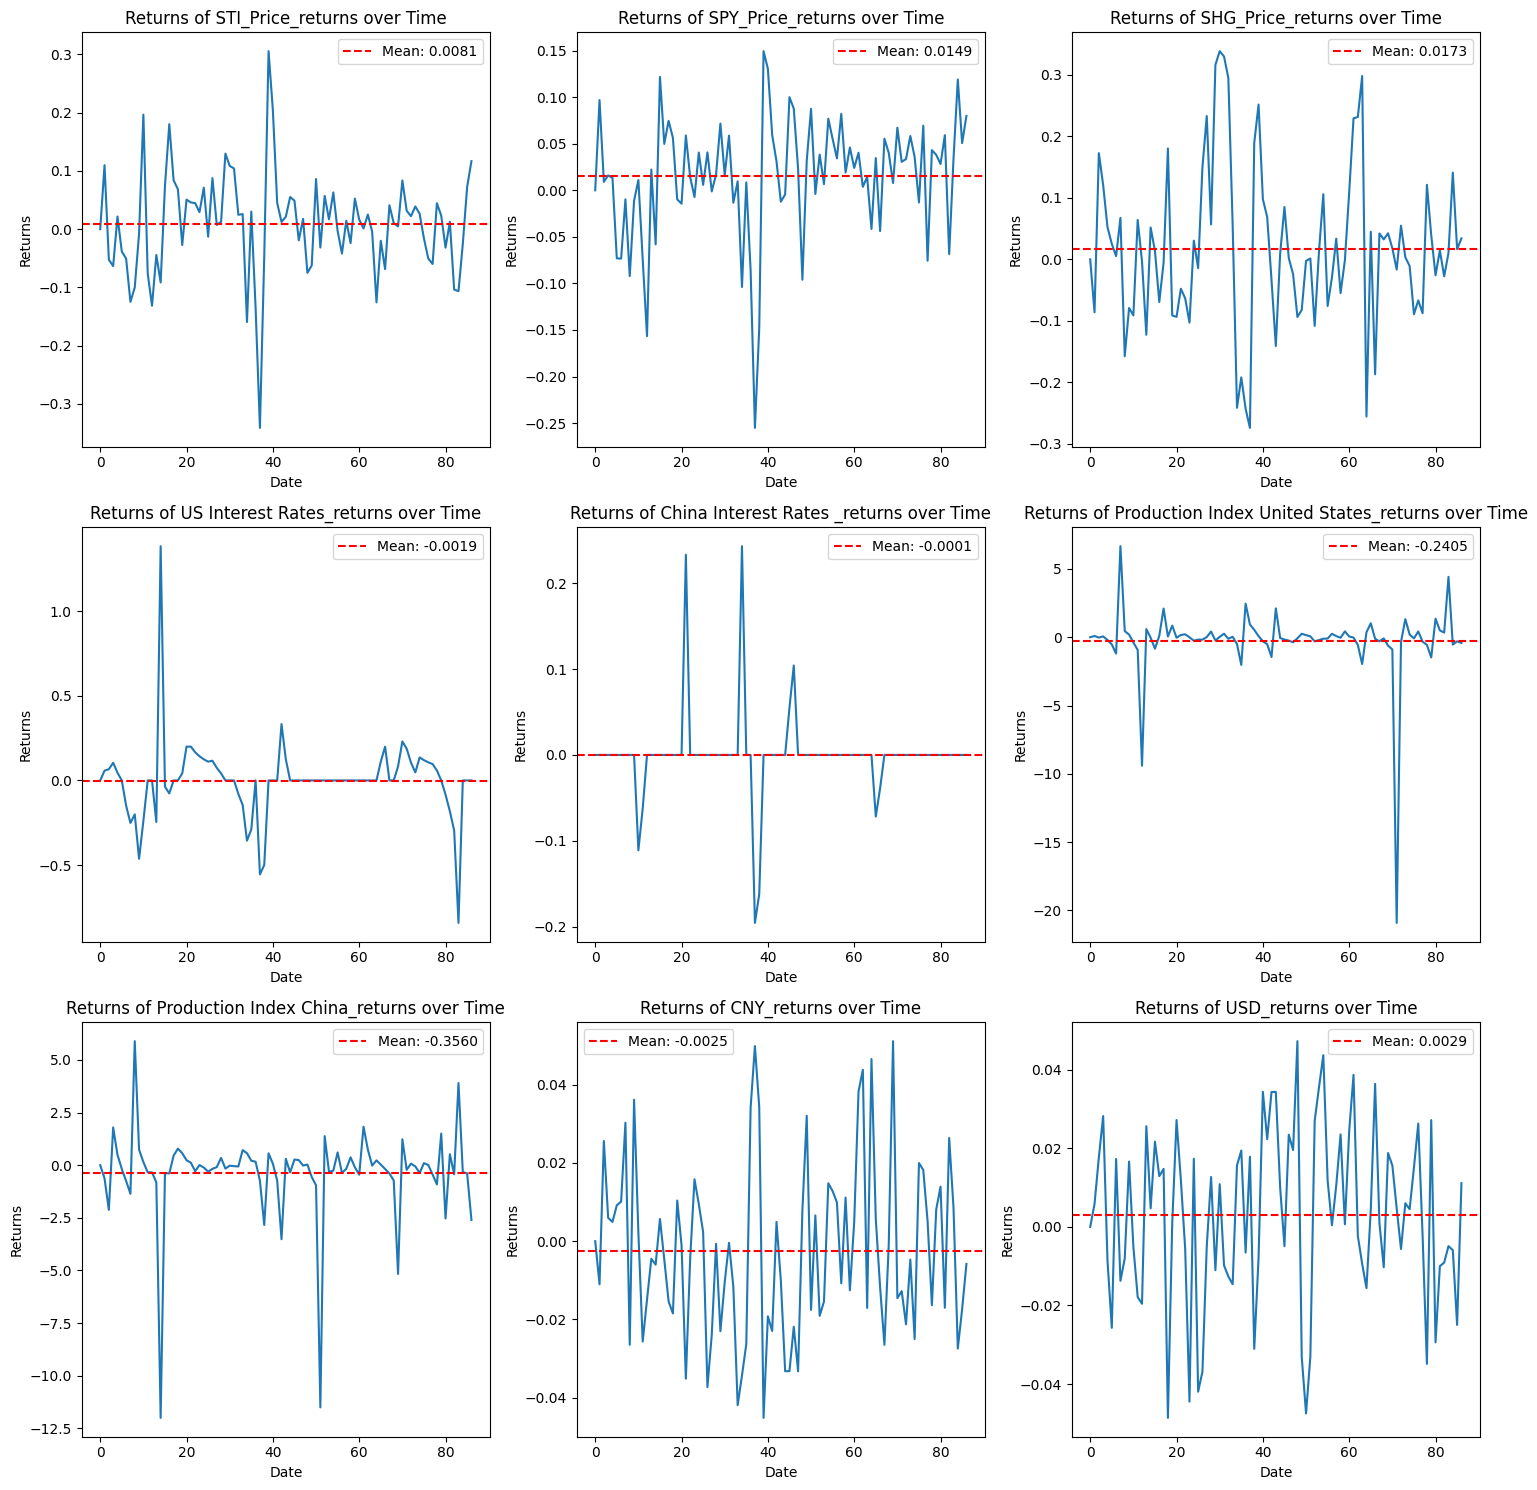

In [8]:

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.lineplot(data=df, x=df.index, y=col+'_returns', ax=axes[i])
    mean_return = df[col+'_returns'].mean()  # Calculate the mean return for the column
    axes[i].axhline(mean_return, color='red', linestyle='--', label=f'Mean: {mean_return:.4f}')
    axes[i].set_title(f"Returns of {col+'_returns'} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()  # Show the legend

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Frequency Distribution - Returns

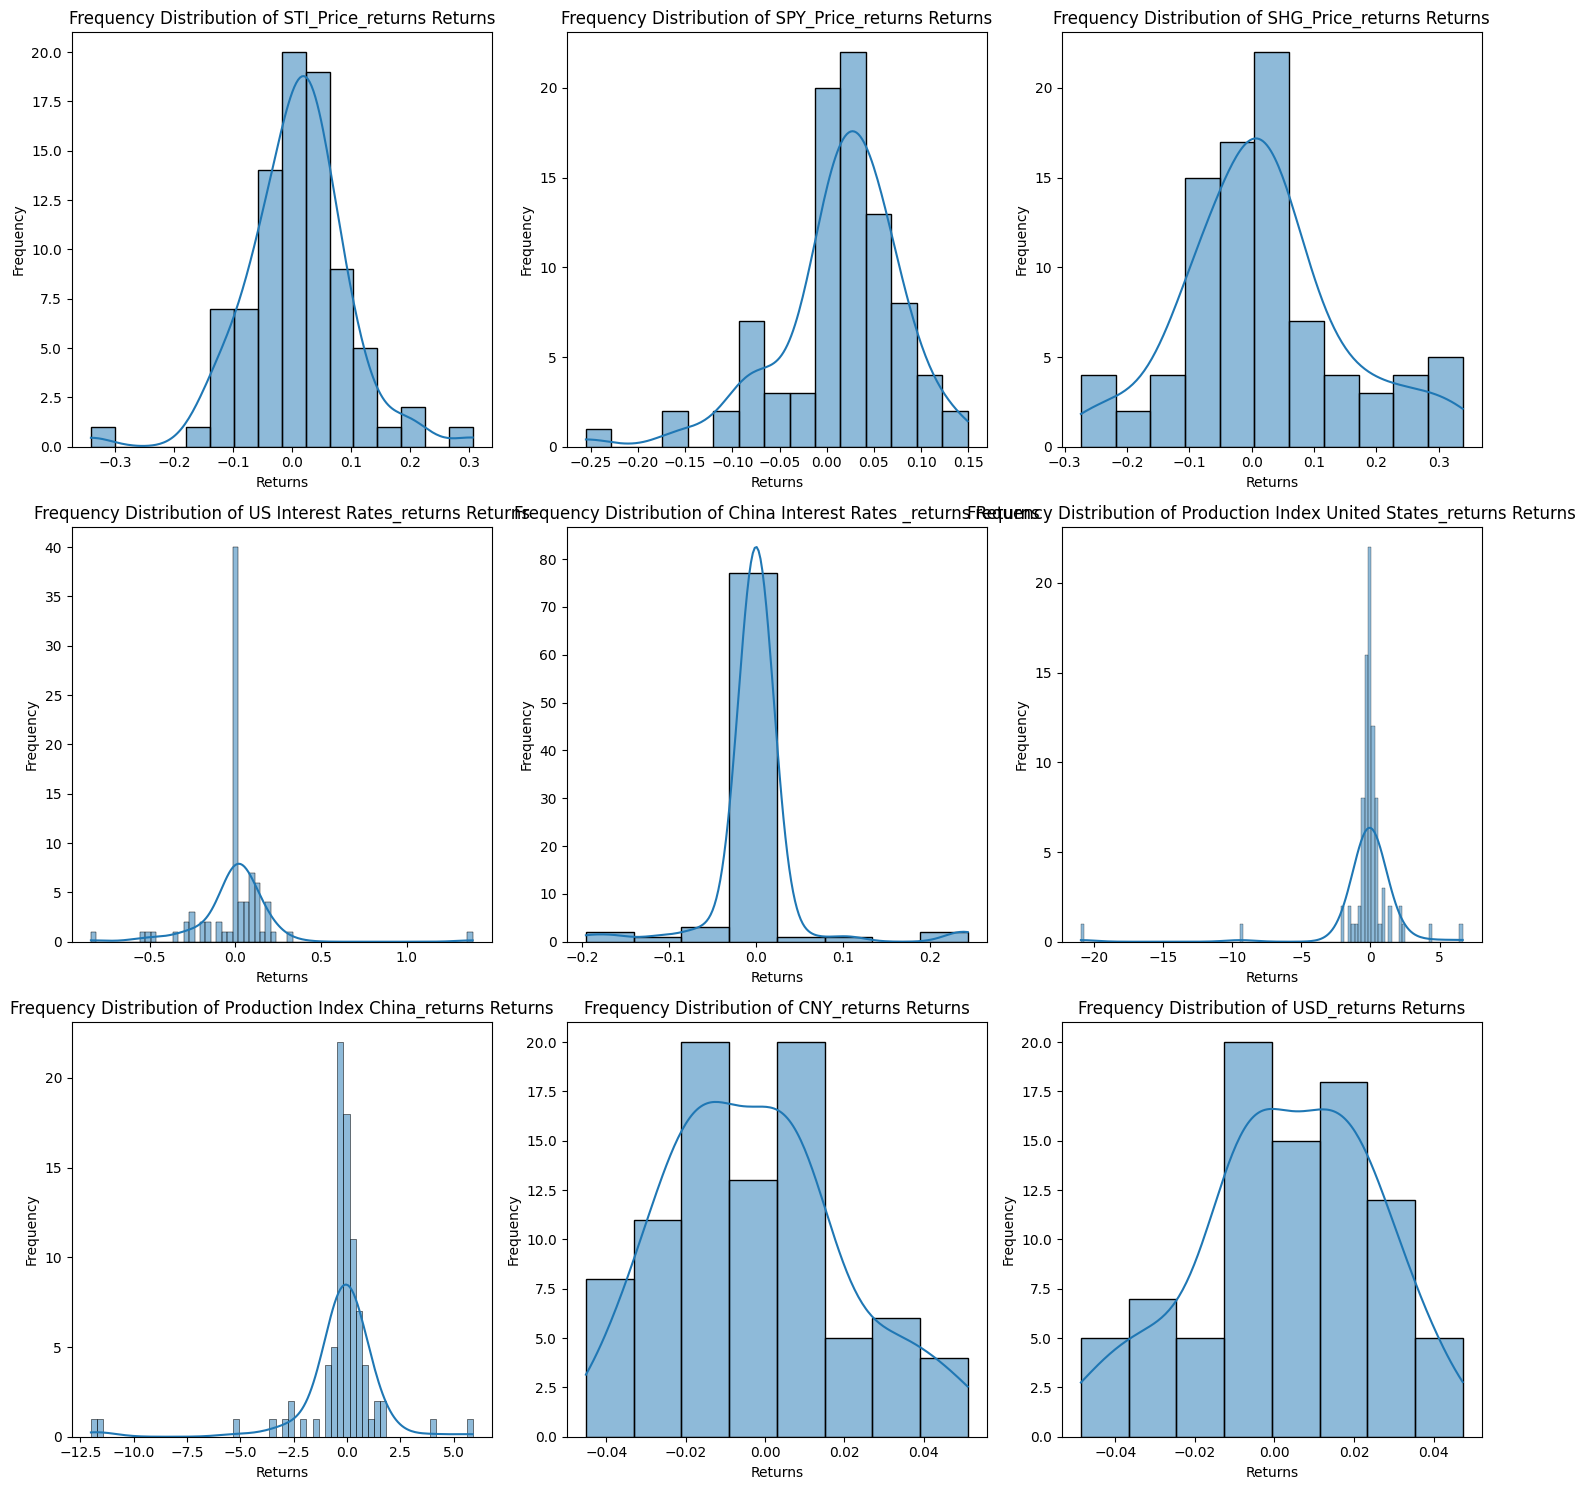

In [9]:
# Plotting frequency distributions
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col+'_returns'], kde=True, ax=axes[i])  # You can use histplot for histograms
    axes[i].set_title(f"Frequency Distribution of {col+'_returns'} Returns")
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Testing Stationary - Unit Root Tests & Decreasing Autocorrellations
*kpss is a proxy of decreasing autocorrelations*

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

# Define a function to perform the ADF test on a series
def perform_adf_test(series):
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value (ADF)': result[1], **result[4]}

# Define a function to check stationarity based on both ADF and KPSS
def is_stationary(row):
    adf_statistic = row['ADF Statistic']
    adf_p_value = row['p-value (ADF)']
    kpss_p_value = row['p-value (KPSS)']
    
    return adf_p_value < 0.05 and adf_statistic < row['1%'] and kpss_p_value > 0.05

# Initialize a list to hold test results
results = []
d1_results = []

# Perform ADF and KPSS tests on each series and store the results in the 'results' list
for col in cols_to_plot:
    adf_result = perform_adf_test(df[col])
    kpss_result = kpss(df[col])
    results.append({**adf_result, 'p-value (KPSS)': kpss_result[1], 'Stationary': is_stationary({**adf_result, 'p-value (KPSS)': kpss_result[1]})})


for col in return_cols_to_plot:
    adf_result = perform_adf_test(df[col])
    kpss_result = kpss(df[col])
    d1_results.append({**adf_result, 'p-value (KPSS)': kpss_result[1], 'Stationary': is_stationary({**adf_result, 'p-value (KPSS)': kpss_result[1]})})

# Convert the results to a DataFrame
stationary_results_df = pd.DataFrame(results, index=cols_to_plot)
stationary_d1_results_df = pd.DataFrame(d1_results, index=return_cols_to_plot)

C:\Users\Charl\AppData\Local\Temp\ipykernel_29632\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_29632\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_29632\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_29632\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greate

In [11]:
# Display the DataFrame
print("ADF and KPSS Test Results (D(0)):")
stationary_results_df.sort_values(by="ADF Statistic")

ADF and KPSS Test Results (D(0)):


,ADF Statistic,p-value (ADF),1%,5%,10%,p-value (KPSS),Stationary
Production Index United States,-4.738997,0.000071,-3.510712,-2.896616,-2.585482,0.100000,True
US Interest Rates,-3.702849,0.004073,-3.511712,-2.897048,-2.585713,0.024704,False
China Interest Rates,-3.566120,0.006443,-3.509736,-2.896195,-2.585258,0.100000,True
Production Index China,-2.570815,0.099180,-3.518281,-2.899878,-2.587223,0.100000,False
STI_Price,-2.058086,0.261699,-3.509736,-2.896195,-2.585258,0.010000,False
SHG_Price,-1.998478,0.287241,-3.512738,-2.897490,-2.585949,0.010718,False
CNY,-1.189168,0.678238,-3.510712,-2.896616,-2.585482,0.010000,False
USD,-0.731810,0.838337,-3.509736,-2.896195,-2.585258,0.010000,False
SPY_Price,2.977513,1.000000,-3.508783,-2.895784,-2.585038,0.010000,False


In [12]:
print("\nADF Test on Returns Data (D(1)):")
stationary_d1_results_df.sort_values(by="ADF Statistic")


ADF Test on Returns Data (D(1)):


,ADF Statistic,p-value (ADF),1%,5%,10%,p-value (KPSS),Stationary
Production Index China_returns,-9.380165,6.992015e-16,-3.508783,-2.895784,-2.585038,0.1,True
Production Index United States_returns,-8.913760,1.086592e-14,-3.508783,-2.895784,-2.585038,0.1,True
USD_returns,-7.637972,1.929603e-11,-3.508783,-2.895784,-2.585038,0.1,True
US Interest Rates_returns,-7.257332,1.717181e-10,-3.508783,-2.895784,-2.585038,0.1,True
SPY_Price_returns,-6.911232,1.210916e-09,-3.508783,-2.895784,-2.585038,0.1,True
STI_Price_returns,-6.741941,3.102912e-09,-3.509736,-2.896195,-2.585258,0.1,True
CNY_returns,-6.571515,7.914444e-09,-3.509736,-2.896195,-2.585258,0.1,True
SHG_Price_returns,-5.366548,3.980530e-06,-3.511712,-2.897048,-2.585713,0.1,True
China Interest Rates,-3.566120,6.442779e-03,-3.509736,-2.896195,-2.585258,0.1,True


## Correllation Matrices

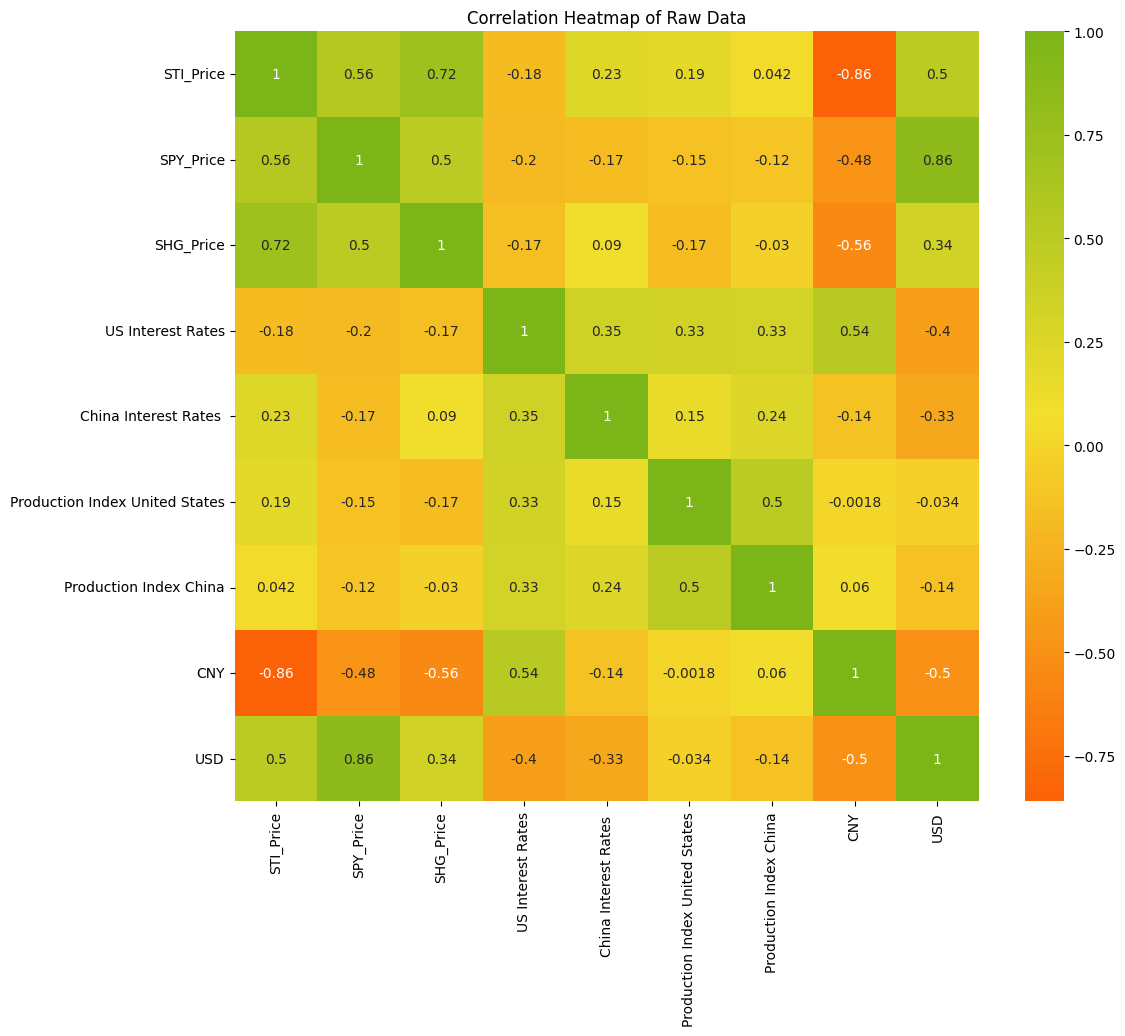

In [13]:
colors = ["#fb6107", "#f3de2c", "#7cb518"]  # Add more colors as desired

# Create the colormap
mint_cmap = LinearSegmentedColormap.from_list("mint_cmap", colors)

corr_matrix_raw = df[cols_to_plot].corr()

corr_matrix_returns = df[return_cols_to_plot].corr()

# Plotting the heatmaps
plt.figure(figsize=(12, 10))

# Heatmap for raw data
sns.heatmap(corr_matrix_raw, annot=True, cmap=mint_cmap)
plt.title('Correlation Heatmap of Raw Data')
plt.show()


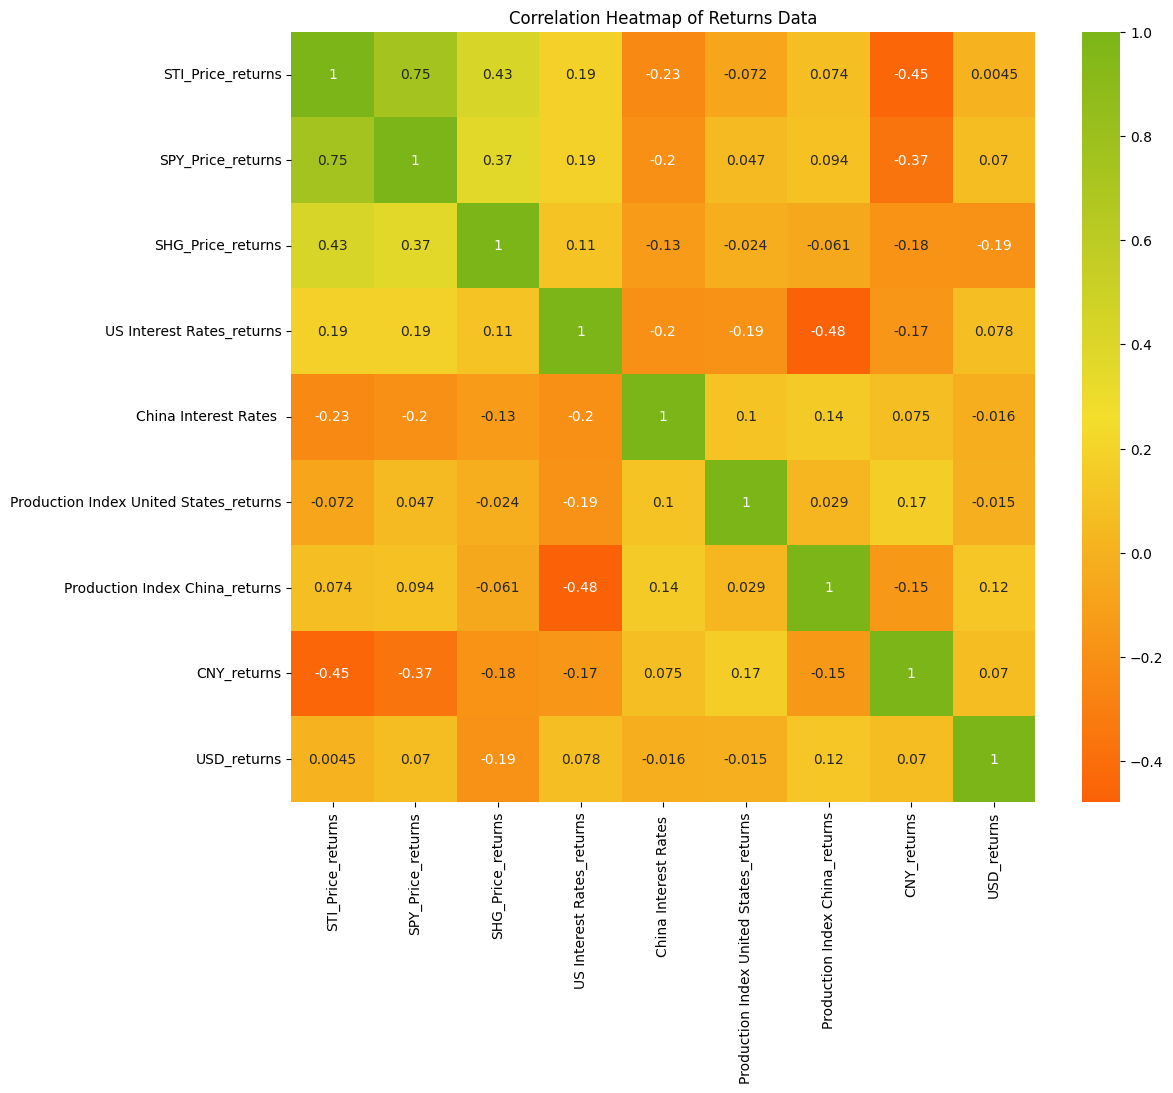

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_returns, annot=True, cmap=mint_cmap)
plt.title('Correlation Heatmap of Returns Data')
plt.show()

# Research

## Crisis Dummy Variables

In [15]:
import pandas as pd
crisis_cutoff = -.1
column = "STI_Price_returns"

# Assuming df is your DataFrame
crisis_bool = (df[column] < crisis_cutoff).to_list()

df["Crisis_Bool"] = crisis_bool
df['Crisis'] = [1 if bool else 0 for bool in crisis_bool]

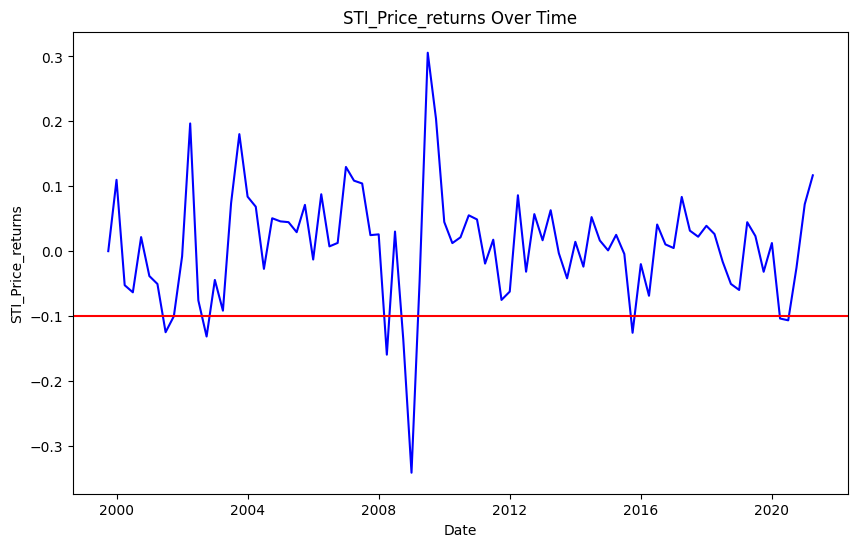

In [16]:
plt.figure(figsize=(10, 6))

# Plot each point, color based on the Crisis column
plt.plot(df["Date"], df[column], color='blue')

# Adding a horizontal line at y = -0.1
plt.axhline(y=-0.1, color='red', linestyle='-')

plt.xlabel('Date')
plt.ylabel(column)
plt.title(f'{column} Over Time')
plt.show()

In [17]:
crisis_dates = df[df['Crisis_Bool']]["Date"]
print(f"Dates when  {column} were below {crisis_cutoff}:")
print(crisis_dates)

Dates when  STI_Price_returns were below -0.1:
7    2001-06-30
8    2001-09-30
12   2002-09-30
34   2008-03-31
36   2008-09-30
37   2008-12-31
64   2015-09-30
82   2020-03-31
83   2020-06-30
Name: Date, dtype: datetime64[ns]


## Granger Causality

In [18]:
pairs = [
    ('STI_Price', 'SHG_Price'),
    ('SHG_Price', 'STI_Price'),
    ('CNY', 'STI_Price'),
    ('STI_Price', 'CNY'),
    ('STI_Price', 'USD'),
    ('USD', 'STI_Price'),
    ('STI_Price', 'SPY_Price'),
    ('SPY_Price', 'STI_Price')
]

In [19]:
def run_granger_causality_tests(df, pairs, maxlag=4):
    """
    Run Granger Causality tests for each pair of variables in the DataFrame.

    Parameters:
    df -- pandas DataFrame containing the time series data
    pairs -- list of tuples, each tuple containing two strings representing the variable names
    maxlag -- integer, the maximum number of lags to test for

    Returns:
    A pandas DataFrame with the Granger Causality test results.
    """
    granger_test_results = []

    for dependent, independent in pairs:
        test_result = grangercausalitytests(df[[dependent, independent]], maxlag=maxlag, verbose=False)
        min_p_value = min(test_result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1))

        granger_test_results.append({
            'dependent': dependent,
            'independent': independent,
            'min_p_value': min_p_value
        })

    granger_df = pd.DataFrame(granger_test_results)
    granger_df["granger_causes"] = granger_df["min_p_value"] <= 0.10

    return granger_df

granger_df = run_granger_causality_tests(df, pairs)

c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

In [20]:
granger_df.sort_values("min_p_value", ascending=True)

,dependent,independent,min_p_value,granger_causes
3,STI_Price,CNY,0.012595,True
5,USD,STI_Price,0.080366,True
1,SHG_Price,STI_Price,0.088542,True
0,STI_Price,SHG_Price,0.100203,False
7,SPY_Price,STI_Price,0.150524,False
2,CNY,STI_Price,0.452324,False
4,STI_Price,USD,0.639058,False
6,STI_Price,SPY_Price,0.680263,False


## Cointegration and Error Correction

In [21]:
cointegration_test_results = []
for dependent, independent in pairs:
    # Retrieve the time series for each variable
    ts_dependent = df[dependent].values
    ts_independent = df[independent].values
    
    # Perform the cointegration test
    coint_t, p_value, _ = coint(ts_dependent, ts_independent)
    
    # Append the results to the list
    cointegration_test_results.append({
        'dependent': dependent,
        'independent': independent,
        'tau-statistic': coint_t,
        'p-value': p_value
    })
cointegration_df = pd.DataFrame(cointegration_test_results)

cointegration_df["cointegrated"] = (cointegration_df["p-value"] <= 0.05) & (cointegration_df["tau-statistic"] < -2)

In [22]:
cointegration_df.sort_values("cointegrated", ascending=False)

,dependent,independent,tau-statistic,p-value,cointegrated
1,SHG_Price,STI_Price,-3.765525,0.015059,True
2,CNY,STI_Price,-3.541558,0.028885,True
3,STI_Price,CNY,-4.142986,0.004443,True
0,STI_Price,SHG_Price,-2.743502,0.184324,False
4,STI_Price,USD,-2.464919,0.294756,False
5,USD,STI_Price,-1.450324,0.779744,False
6,STI_Price,SPY_Price,-2.124480,0.463579,False
7,SPY_Price,STI_Price,1.563380,1.000000,False


## VAR Model

### Functions & Variables

In [23]:
from statsmodels.tsa.api import VAR

def fit_var_and_select_best_aic(df, variable_list, crisis_dummy_column="Crisis", maxlags_list=[1, 2, 4, 8]):
    """
    Fit VAR models to the specified variables within the dataframe for a set of lags, including a crisis dummy variable.
    Select the model with the lowest AIC.
    
    Parameters:
    df -- pandas DataFrame containing the time series data
    variable_list -- list of column names to be included in the VAR model
    crisis_dummy_column -- the name of the column containing the crisis dummy variable
    maxlags_list -- list of integers for the maximum lag order to consider
    
    Returns:
    A tuple containing the best AIC value and the corresponding VARResults object
    """
    best_aic = float('inf')
    best_model = None
    df_selected_vars = df[variable_list + [crisis_dummy_column]]
    
    for lags in maxlags_list:
        model = VAR(df_selected_vars)
        results = model.fit(maxlags=lags, ic='aic')
        print(lags, results.aic)
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
    
    return best_aic, best_model


In [24]:
USA_cols = ['STI_Price_returns', 'SPY_Price_returns', 'US Interest Rates', 'Production Index United States_returns', 'USD_returns']
CHN_cols = ['STI_Price_returns', 'SHG_Price_returns', 'CNY_returns', 'Production Index China_returns', 'China Interest Rates ']

### Determining Optimal Lag Length

In [25]:
_, chn_model = fit_var_and_select_best_aic(df, CHN_cols)

1 -22.364821018260216
2 -22.364821018260216
4 -22.364821018260216
8 -22.34406827400594


In [26]:
_, usa_model = fit_var_and_select_best_aic(df, USA_cols, maxlags_list=[1, 2, 4, 8])

1 -21.32038035664919
2 -21.352401870601295
4 -21.352401870601295
8 -21.730831339387038


### Impulse Reponse 

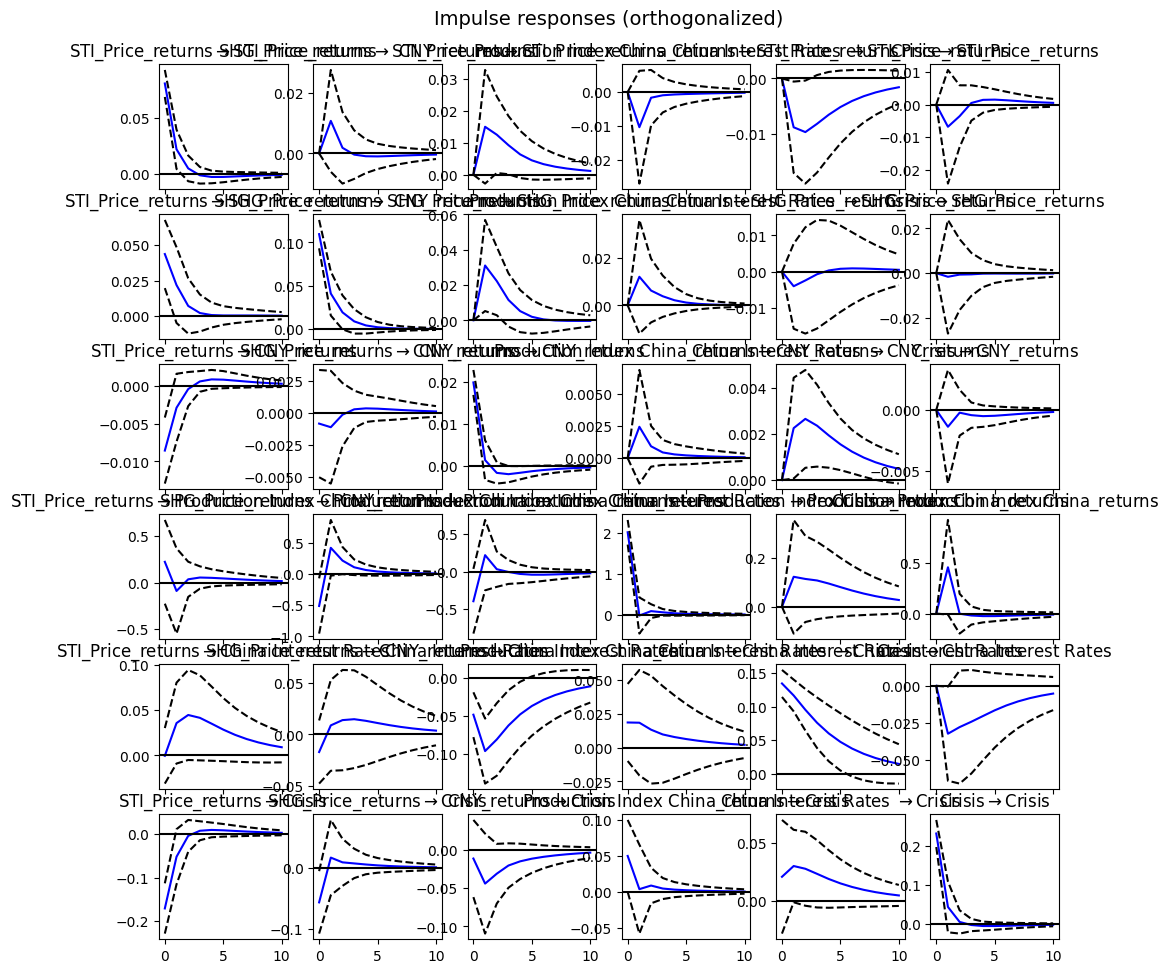

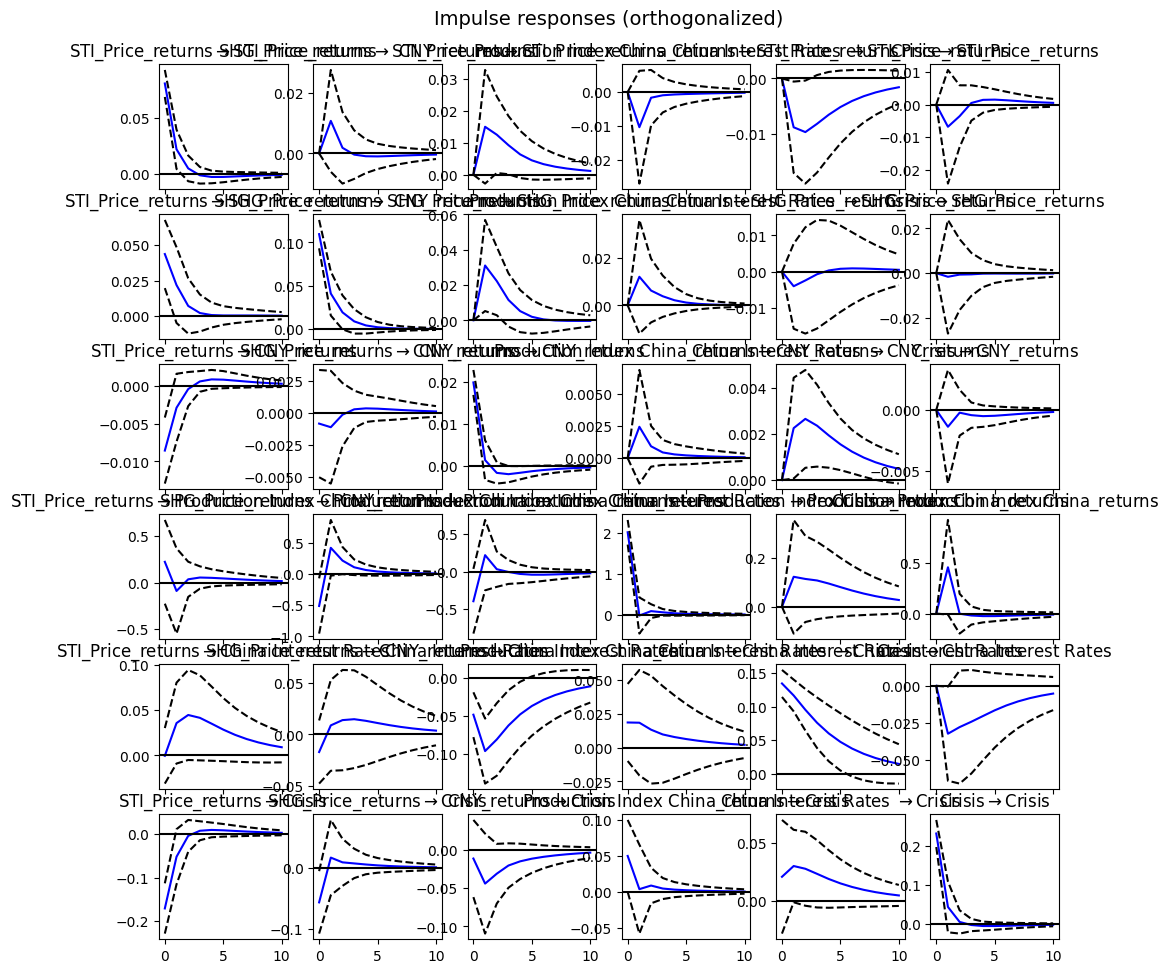

In [27]:
china_irf = chn_model.irf(10)

china_irf.plot(orth=True)

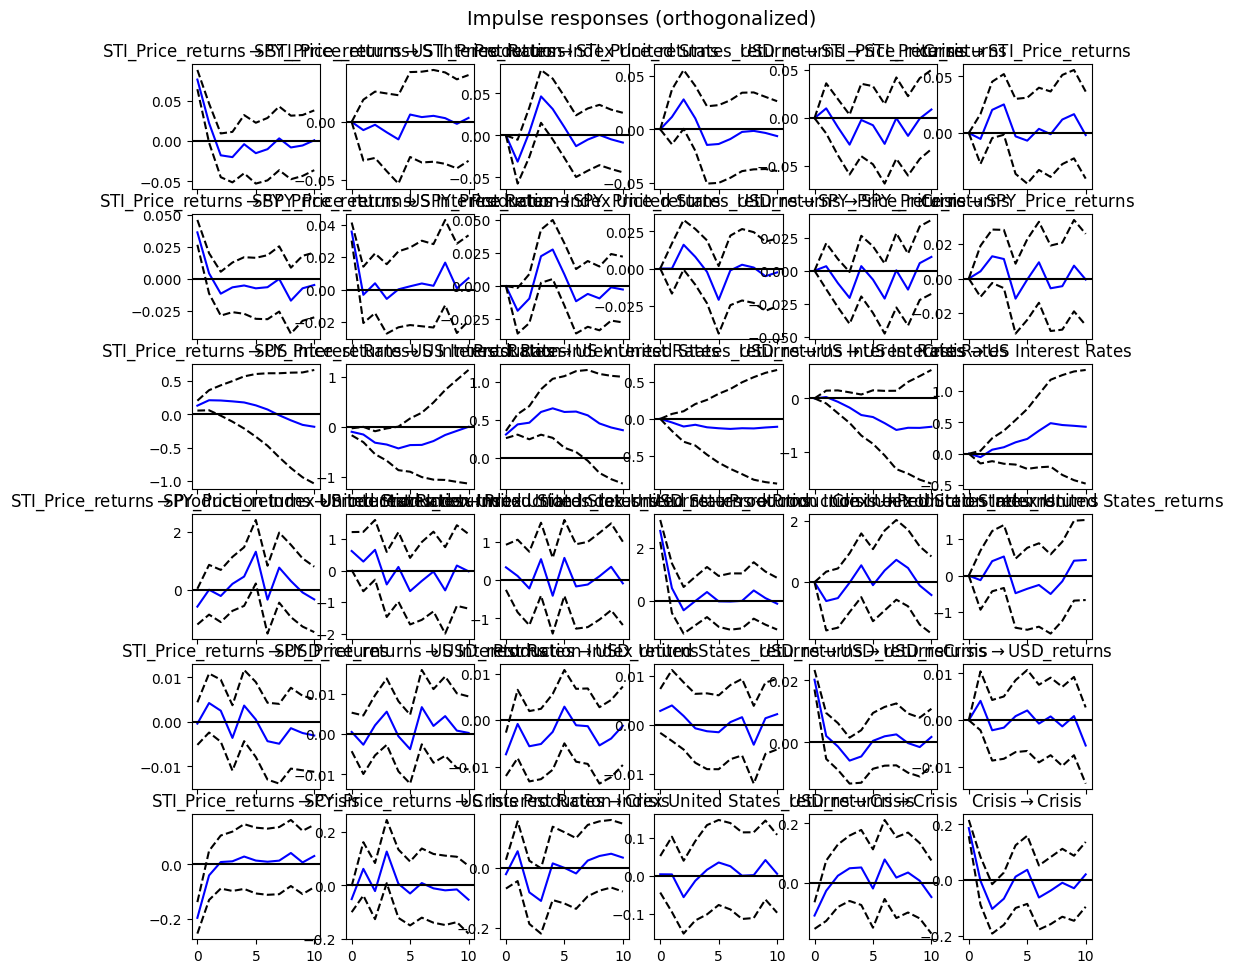

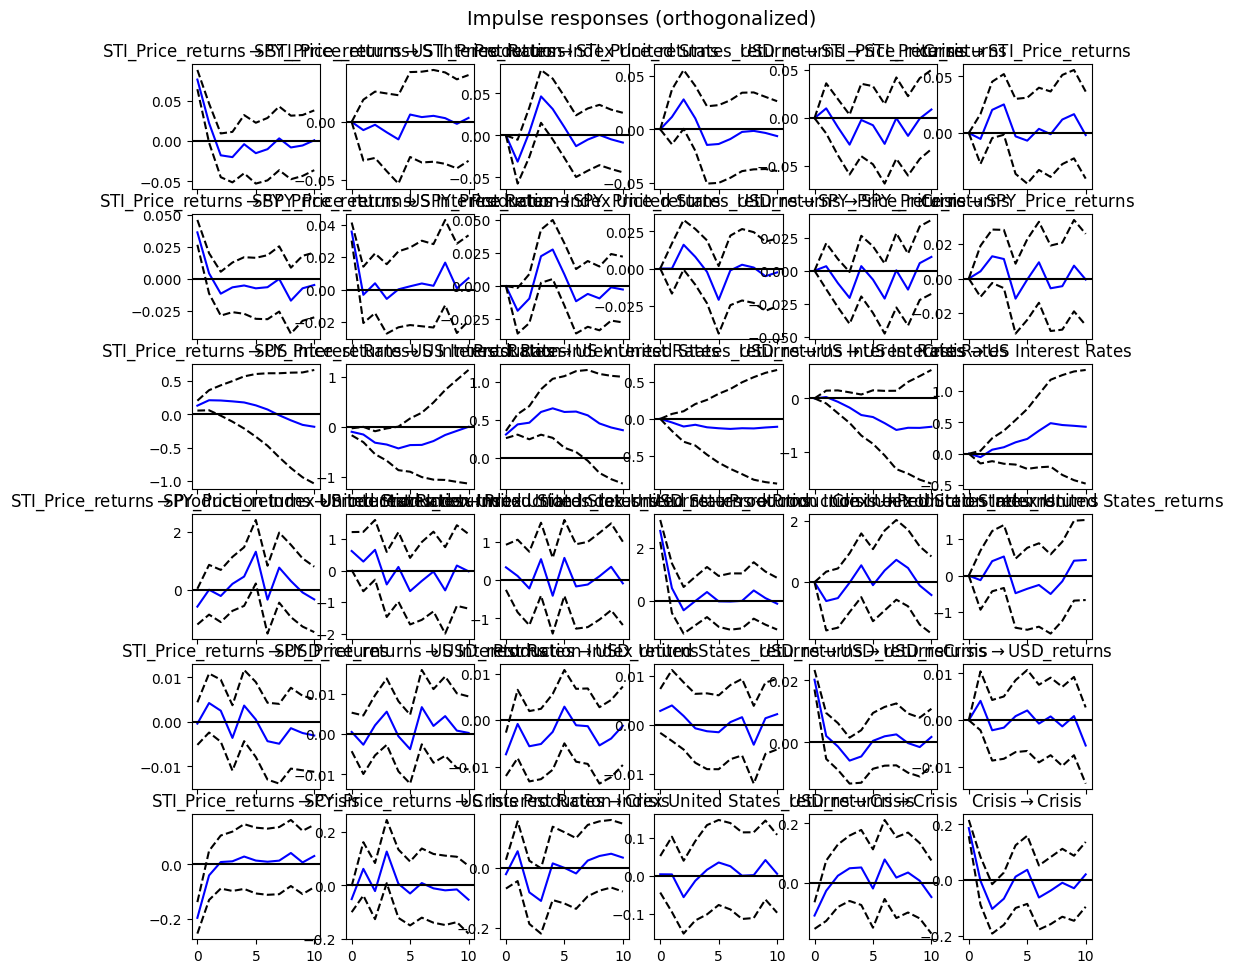

In [28]:
usa_irf = usa_model.irf(10)

usa_irf.plot(orth=True)

## ARDL Model

### ARDL Model Selection Process
Determine best model off of 

In [29]:
# ARDL Model Function
from statsmodels.tsa.api import ARDL
def fit_ardl_and_get_metrics(df, dependent_var, independent_vars, lags):
    """
    Fit an ARDL model and return Durbin Watson score, Schwartz Criterion (BIC), residuals, and R squared.

    Parameters:
    df -- pandas DataFrame containing the time series data
    dependent_var -- the name of the column containing the dependent variable
    independent_vars -- list of names of columns containing the independent variables
    crisis_dummy -- the name of the column containing the crisis dummy variable
    lags -- integer specifying the lag level

    Returns:
    A dictionary with Durbin Watson score, Schwartz Criterion (BIC), residuals, and R squared
    """
    # Preparing the data
    df = df.copy()
    df.dropna(inplace=True)
    X = df[independent_vars]
    y = df[dependent_var]

    # Ensure the index of y aligns with X after dropping NaNs
    y = y[y.index.isin(X.index)]

    # Specifying the order for ARDL model (lags for each independent variable)
    order = {var: (1, lags) for var in independent_vars}  # (0, lags) specifies no AR lags but lags for exogenous variables

    ardl_model = ARDL(y, lags=lags, order=order, exog=X, trend='c', causal=False).fit()

    residuals = ardl_model.resid
    SSR = sum(residuals ** 2)

    # You need the actual values of the dependent variable, say `y_actual`
    TSS = sum((y - y.mean()) ** 2)

    r_squared = 1 - (SSR / TSS)
    
    metrics = {
        'Durbin Watson'
        : sm.stats.durbin_watson(ardl_model.resid),
        'Schwartz Criterion (BIC)': ardl_model.bic,
        'Residuals': residuals,
        'R Squared': r_squared
    }

    return metrics, ardl_model

In [30]:
CHN_independent = ['SHG_Price_returns',
 'CNY_returns',
 'Production Index China_returns',
 'China Interest Rates _returns']

USA_independent = ['SPY_Price_returns',
 'US Interest Rates_returns',
 'Production Index United States_returns',
 'USD_returns']

In [31]:
from itertools import combinations, product

def select_best_ardl_model(df, dependent_var, all_independent_vars, crisis_dummy, lags_list):
    """
    Iterate through all combinations of independent variables and lags to find the best ARDL model based on R-squared.

    Parameters:
    df -- pandas DataFrame containing the time series data
    dependent_var -- the name of the column containing the dependent variable
    all_independent_vars -- list of all possible independent variables
    crisis_dummy -- the name of the column containing the crisis dummy variable
    lags_list -- list of integers specifying the lag levels to consider

    Returns:
    A tuple containing the best model and its metrics
    """
    best_r_squared = float('-inf')
    best_model_metrics = None

    for num_vars in range(1, len(all_independent_vars) + 1):
        for vars_combination in combinations(all_independent_vars, num_vars):
            for lags in lags_list:
                vars_combination = list(vars_combination) + [crisis_dummy]
                model_metrics, model = fit_ardl_and_get_metrics(df, dependent_var, vars_combination,  lags)
                if model_metrics['R Squared'] > best_r_squared:
                    best_r_squared = model_metrics['R Squared']
                    best_model_metrics = model_metrics
                    best_model = model

    print(best_model.summary())
    return best_model_metrics, best_model


In [32]:
china_best_model_metrics, china_best_model = select_best_ardl_model(df, 'STI_Price_returns', CHN_independent, "Crisis", [2, 4, 8, 12])

                                   ARDL Model Results                                   
Dep. Variable:                STI_Price_returns   No. Observations:                   87
Model:             ARDL(12, 12, 12, 12, 12, 12)   Log Likelihood                 115.890
Method:                         Conditional MLE   S.D. of innovations              0.052
Date:                          Tue, 05 Dec 2023   AIC                           -183.781
Time:                                  16:58:15   BIC                           -128.161
Sample:                                      12   HQIC                          -161.572
                                             87                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.0184      0.010      1.853      0.070    

In [33]:
usa_best_model_metrics, usa_best_model = select_best_ardl_model(df, 'STI_Price_returns', USA_independent, "Crisis", [2, 4, 8, 12])

                                   ARDL Model Results                                   
Dep. Variable:                STI_Price_returns   No. Observations:                   87
Model:             ARDL(12, 12, 12, 12, 12, 12)   Log Likelihood                 119.939
Method:                         Conditional MLE   S.D. of innovations              0.049
Date:                          Tue, 05 Dec 2023   AIC                           -191.879
Time:                                  16:58:16   BIC                           -136.259
Sample:                                      12   HQIC                          -169.671
                                             87                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.0322      0.010  

#### ARDL White Noise Residual Testing
* Normal Distribution of Residuals
* Schwartz Criterion
* Durbin-Watson Score
* Autocorrelation of Residuals

In [34]:
residuals = usa_best_model_metrics["Residuals"]

shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk Test: ", shapiro_test)

# Test for autocorrelation
durbin_watson_statistic = sm.stats.durbin_watson(residuals)
print("Durbin-Watson Statistic: ", durbin_watson_statistic)

Shapiro-Wilk Test:  ShapiroResult(statistic=0.9717610478401184, pvalue=0.09183729439973831)
Durbin-Watson Statistic:  2.218085792779831


In [35]:
residuals = china_best_model_metrics["Residuals"]

shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk Test: ", shapiro_test)

# Test for autocorrelation
durbin_watson_statistic = sm.stats.durbin_watson(residuals)
print("Durbin-Watson Statistic: ", durbin_watson_statistic)

Shapiro-Wilk Test:  ShapiroResult(statistic=0.9875328540802002, pvalue=0.6756013631820679)
Durbin-Watson Statistic:  2.15519786985693


# Conclusion
Both countries have very similar relationship to Singapore's major stock market with both observing ARDL(short term relationships) & through ARDL regression models.

One striking dissimilarity is China's evidence of cointegration which indiciates a long term relationship between China's economy & Singapore Markets. It is not certain however that because of this China necessarily has a stronger relationship with Singapore. 

In the future I'd like to repeat these steps for all middle economies in the Pacific & North America. Also it would be interesting to do every other middle economic power in the world to see which of the 2 super powers have a stronger economic pull. 